In [1]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_colwidth', None)
sns.set_palette("icefire")

# Import Dataset

In [2]:
df = pd.read_csv('Eluvio_DS_Challenge.csv', parse_dates=True, index_col='date_created')
df.head(10)

,time_created,up_votes,down_votes,title,over_18,author,category
date_created,,,,,,,
2008-01-25,1201232046,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
2008-01-25,1201232075,2,0,Japan resumes refuelling mission,False,polar,worldnews
2008-01-25,1201232523,3,0,US presses Egypt on Gaza border,False,polar,worldnews
2008-01-25,1201233290,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
2008-01-25,1201274720,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
2008-01-25,1201287889,15,0,Hay presto! Farmer unveils the illegal mock-Tudor castle he tried to hide behind 40ft hay bales,False,Armagedonovich,worldnews
2008-01-25,1201289438,5,0,"Strikes, Protests and Gridlock at the Poland-Ukraine Border",False,Clythos,worldnews
2008-01-28,1201536662,0,0,The U.N. Mismanagement Program,False,Moldavite,worldnews
2008-01-28,1201558396,4,0,Nicolas Sarkozy threatens to sue Ryanair,False,Moldavite,worldnews


## Stats

In [163]:
df.shape

(509236, 8)

In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 509236 entries, 2008-01-25 to 2016-11-22
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   time_created  509236 non-null  int64 
 1   up_votes      509236 non-null  int64 
 2   down_votes    509236 non-null  int64 
 3   title         509236 non-null  object
 4   over_18       509236 non-null  bool  
 5   author        509236 non-null  object
 6   category      509236 non-null  object
dtypes: bool(1), int64(3), object(3)
memory usage: 27.7+ MB


In [5]:
df.describe()

,time_created,up_votes,down_votes
count,5.092360e+05,509236.000000,509236.0
mean,1.380240e+09,112.236283,0.0
std,7.090436e+07,541.694675,0.0
min,1.201232e+09,0.000000,0.0
25%,1.341585e+09,1.000000,0.0
50%,1.392909e+09,5.000000,0.0
75%,1.436527e+09,16.000000,0.0
max,1.479817e+09,21253.000000,0.0


In [6]:
df.nunique()

time_created    508329
up_votes          5782
down_votes           1
title           500720
over_18              2
author           85838
category             1
dtype: int64

In [7]:
df.index

DatetimeIndex(['2008-01-25', '2008-01-25', '2008-01-25', '2008-01-25',
               '2008-01-25', '2008-01-25', '2008-01-25', '2008-01-28',
               '2008-01-28', '2008-01-29',
               ...
               '2016-11-22', '2016-11-22', '2016-11-22', '2016-11-22',
               '2016-11-22', '2016-11-22', '2016-11-22', '2016-11-22',
               '2016-11-22', '2016-11-22'],
              dtype='datetime64[ns]', name='date_created', length=509236, freq=None)

## Clean Dataset

In [3]:
# remove unnecessary columns
worldnews = df.drop(columns=['time_created','down_votes','category'])
worldnews.head()

,up_votes,title,over_18,author
date_created,,,,
2008-01-25,3,Scores killed in Pakistan clashes,False,polar
2008-01-25,2,Japan resumes refuelling mission,False,polar
2008-01-25,3,US presses Egypt on Gaza border,False,polar
2008-01-25,1,Jump-start economy: Give health care to all,False,fadi420
2008-01-25,4,Council of Europe bashes EU&UN terror blacklist,False,mhermans


# EDA

## Repeating Titles

In [13]:
rep_titles = pd.DataFrame(worldnews.title.value_counts()).rename(columns={'title':'n_posts'})
rep_titles = rep_titles[rep_titles['n_posts'] > 1]
rep_titles.head(10)

,n_posts
Brutality of Syrian Rebels Posing Dilemma in West,6
David Cameron to quit after UK votes to leave EU,5
Putin nominated for Nobel Peace Prize,5
South Korea reveals it has a plan to assassinate Kim Jong Un,5
Samsung Galaxy Note 3 Leaked camera image,5
Obama Administration Ends Pentagon Program to Train Syrian Rebels,5
Syria Militants Said to Recruit Visiting Americans to Attack U.S.,5
Swiss tourist gang-raped in India,5
Hungarian nationalist TV camera operator filmed kicking refugee children,5
ISIS more dangerous than people realize,5


In [11]:
rep_titles.iloc[0].name

'Brutality of Syrian Rebels Posing Dilemma in West'

In [14]:
worldnews[worldnews['title'] == rep_titles.iloc[0].name]\
    .loc[:,['author','up_votes','over_18']]\
    .sort_values(by='up_votes', ascending=False)

,author,up_votes,over_18
date_created,,,
2013-09-06,BillTowne,57,False
2013-09-06,GreyMatter22,31,False
2013-09-05,0x0E,28,False
2013-09-05,Jewpiter,19,False
2013-09-05,erowidtrance,12,False
2013-09-05,emr1028,7,False


These titles seem to be re-posts of the same news article. For example [`Jewpiter`](https://www.reddit.com/r/worldnews/comments/1ls2q0/brutality_of_syrian_rebels_posing_dilemma_in_west/) and [`erowidtrance`](https://www.reddit.com/r/worldnews/comments/1lsskg/brutality_of_syrian_rebels_posing_dilemma_in_west/) both made posts on the same [NYTimes article](https://www.nytimes.com/2013/09/05/world/middleeast/brutality-of-syrian-rebels-pose-dilemma-in-west.html). For future text analysis, we should make sure we only view the unique titles.

Also, even though `BillTowne` and `GreyMatter22` re-posted the same article a day after everyone else, they still got the most up votes (I think that's funny).

## Activity Over Time

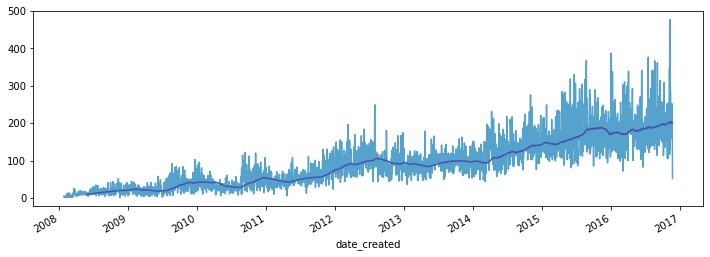

In [220]:
worldnews.groupby('date_created')['up_votes'].mean().plot()
worldnews.groupby('date_created')['up_votes'].mean().rolling(window=120).mean().plot(figsize= (12, 4))

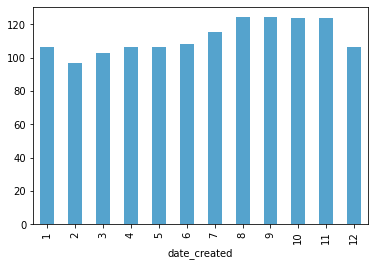

In [224]:
worldnews.groupby(worldnews.index.month)['up_votes'].mean().plot.bar()

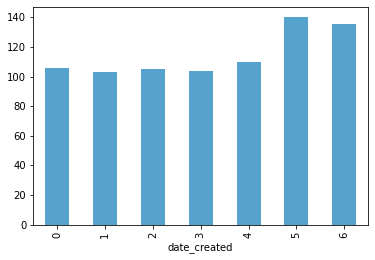

In [226]:
worldnews.groupby(worldnews.index.dayofweek)['up_votes'].mean().plot.bar()

## Top Authors (up-votes, number of posts)

In [127]:
def posts_by(author, n=10):
    return worldnews[worldnews['author'] == author].sort_values(by='up_votes', ascending=False)[0:n]

### By Up-Votes

In [118]:
top_10_authors = pd.DataFrame(worldnews.groupby('author')['up_votes'].sum())\
    .assign(n_over_18 = worldnews.groupby('author')['over_18'].sum())\
    .sort_values(by='up_votes', ascending=False)[0:10]
    
top_10_authors.reset_index(drop=False, inplace=True)

Text(0.5, 1.0, 'Most up-voted authors')

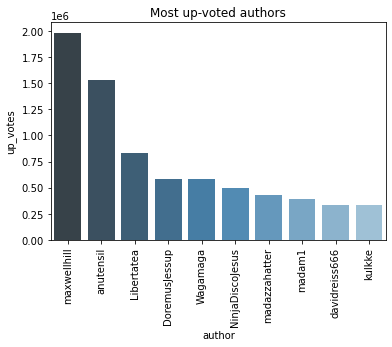

In [119]:
ax = sns.barplot(x='author', 
                 y='up_votes', 
                 data=top_10_authors,
                 palette='Blues_d')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Most up-voted authors')

In [128]:
posts_by('maxwellhill')

,up_votes,title,over_18,author
date_created,,,,
2016-08-31,7925,Alzheimer s disease breakthrough as new drug clears toxic proteins from brains of patients,False,maxwellhill
2016-08-11,7596,Scotland just produced enough wind energy to power it for an entire day: Strong winds combined with low demand on a sunny summer Sunday help Scotland reach ‘significant milestone’ on path towards ditching fossil fuels entirely,False,maxwellhill
2015-10-28,7568,The star witness in a case pitting rainforest villagers against a multinational oil giant has admitted to lying under oath in an effort to help Chevron avoid paying a $9.5 billion judgment for deliberate pollution of the Ecuadorian Amazon,False,maxwellhill
2016-11-11,7430,"Mexico s avengers backed by public sick of crime and lack of punishment: A wave of vigilante killings – such as the bus passenger who shot four robbers – has struck a chord with Mexicans fed up with crime, corruption and impunity",False,maxwellhill
2016-08-04,7386,"Italy passes law to encourage all supermarkets to give unsold food to needy: The food currently wasted in Europe could feed 200 million people, says the UN Food and Agricultural",False,maxwellhill
2016-11-02,7332,"Montreal police tracked journalist s iPhone: “I was living in the fiction that police officers wouldn’t dare do that, and in the fiction that judges were protecting journalists -- and hence the public -- against this type of police intrusion,” Lagace said. “Clearly, I was naive.”",False,maxwellhill
2016-05-30,7290,"Denmark to stop paying salary to royal family grandchildren: Simple mathematics dictate that there needs to be some sort of limit. Otherwise within a few generations there will be several hundred princes and princesses who need an annual salary, says a ruling party spokesman",False,maxwellhill
2016-06-05,7287,Pope Francis reveals new church law to deal with paedophile priests: Catholic bishops who fail to sack paedophile priests can be removed from office,False,maxwellhill
2016-09-30,7252,EU plan to give free Interrail pass to every 18-year-old in Europe on their birthday: The mobility of young people is essential in promoting a sense of belonging to Europe,False,maxwellhill


## By Number of Posts

In [125]:
n_posts = pd.DataFrame(worldnews.author.value_counts())\
    .rename(columns={'author':'n_posts'})[0:10]
n_posts.reset_index(drop=False, inplace=True)

Text(0.5, 1.0, 'Number of posts per authors')

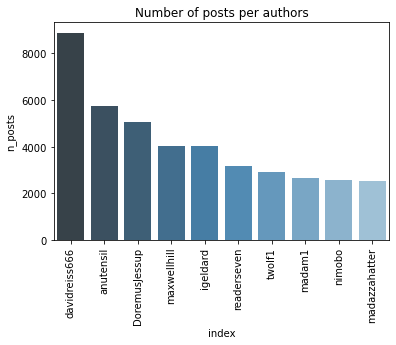

In [126]:
ax = sns.barplot(x='index', 
                 y='n_posts', 
                 data=n_posts[0:10],
                 palette='Blues_d')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Number of posts per authors')

In [131]:
posts_by('davidreiss666')

,up_votes,title,over_18,author
date_created,,,,
2014-08-21,4833,"The president of Indonesia, the world’s most populous Muslim-majority country, deemed the actions of the Islamic State in Iraq and Syria group “embarrassing” to the religion and called upon Muslim leaders to unite in tackling extremism",False,davidreiss666
2014-11-12,4407,"Study: Brazilian cops killed more than 11,000 people in 5 years",False,davidreiss666
2014-06-11,4141,Chile rejects Patagonia wilderness dam project: The Chilean government has rejected a plan to build five hydroelectric dams on rivers in the south of the country. Its decision follows years of campaigning by environmentalists and local communities.,False,davidreiss666
2012-10-23,3299,"A 28-year-old Tunisian who was caught on security camera stealing from a man who had fallen onto the tracks on the Stockholm subway and then leaving him to be hit by a train was sentenced to prison, deportation",False,davidreiss666
2014-04-12,3062,"Armed men dressed in camouflage clothing have seized a police station in eastern Ukraine, officials say.",False,davidreiss666
2012-09-27,3025,Slavery Still Exists: Photographs of human trafficking and enslavement around the world,False,davidreiss666
2012-08-10,3013,"Commerzbank stops speculating on basic food prices: Germany s second-biggest lender, Commerzbank, says it will no longer participate in market speculation on basic food prices. The bank says it has removed all agricultural products from its funds for moral reasons.",False,davidreiss666
2013-01-16,2767,"Insecticide unacceptable danger to bees, report finds -- Campaigners say the conclusion by the European Food Safety Authority is a death knell for neonicotinoid pesticides",False,davidreiss666
2013-08-02,2759,"Berthold Beitz, a leading German industrialist who was credited with saving hundreds of Jews during World War II by employing them at the oil fields he managed in Nazi-occupied Poland, a rescue operation later compared to the more popularly known deeds of Oskar Schindler, died July 30. He was 99.",False,davidreiss666


## Author Activity: TODO: make neater

In [386]:
import calendar
def author_activity(author):
    # filter by author name
    temp = worldnews.filter(items=['up_votes','author'])[worldnews['author'] == author]
    
    # create new columns to groupby
    temp['year'] = temp.index.year
    temp['month'] = temp.index.month
    temp['month'] = temp['month'].apply(lambda x: calendar.month_abbr[x])
    temp.reset_index(drop=True, inplace=True)
    
    # aggregate
    temp = temp.groupby(['year', 'month'])\
               .agg({'up_votes':'sum','author':'count'})\
               .rename(columns={'author':author[0:3]+'_posts', 'up_votes':author[0:3] + '_votes'})
    
    return temp

In [387]:
auth1 = 'davidreiss666' 
auth2 = 'maxwellhill'

auth1_act = author_activity(auth1)
auth2_act = author_activity(auth2)

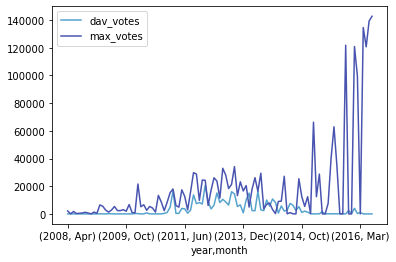

In [388]:
df_likes = pd.concat([auth1_act.iloc[:,0], auth2_act.iloc[:,0]], axis=1).fillna(0)
df_likes.plot()

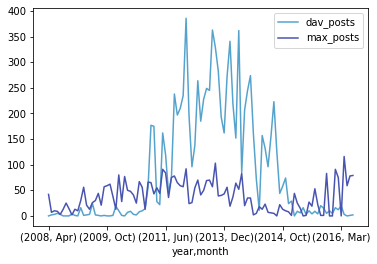

In [389]:
df_posts = pd.concat([auth1_act.iloc[:,1], auth2_act.iloc[:,1]], axis=1).fillna(0)
df_posts.plot()

## Top Posts

In [17]:
worldnews.up_votes.describe()

count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64

In [18]:
worldnews.sort_values(by="up_votes", ascending=False)[0:10]

,up_votes,title,over_18,author
date_created,,,,
2015-06-20,21253,"A biotech startup has managed to 3-D print fake rhino horns that carry the same genetic fingerprint as the actual horn. The company plans to flood Chinese rhino horn market at one-eighth of the price of the original, undercutting the price poachers can get and forcing them out eventually.",False,KRISHNA53
2015-08-24,13435,"Twitter has forced 30 websites that archive politician s deleted tweets to shut down, removing an effective tool to keep politicians honest",False,joeyoungblood
2016-04-03,13244,"2.6 terabyte leak of Panamanian shell company data reveals how a global industry led by major banks, legal firms, and asset management companies secretly manages the estates of politicians, Fifa officials, fraudsters and drug smugglers, celebrities and professional athletes.",False,mister_geaux
2015-08-23,12333,"The police officer who leaked the footage of the surfers paradise police brutality, where the victims blood was washed away by officers, has been criminally charged for bringing it to the publics view. Officers who did the bashing get nothing.",False,navysealassulter
2015-08-18,11288,Paris shooting survivor suing French media for giving away his location while he hid from shooters,False,seapiglet
2016-03-30,11108,Hundreds of thousands of leaked emails reveal massively widespread corruption in global oil industry,False,Xiroth
2015-09-18,10922,Brazil s Supreme Court has banned corporate contributions to political campaigns and parties,False,DoremusJessup
2015-08-20,10515,"ISIS beheads 81-year-old pioneer archaeologist and foremost scholar on ancient Syria. Held captive for 1 month, he refused to tell ISIS the location of the treasures of Palmyra unto death.",False,DawgsOnTopUGA
2016-10-19,10394,"Feeding cows seaweed could slash global greenhouse gas emissions, researchers say: They discovered adding a small amount of dried seaweed to a cow s diet can reduce the amount of methane a cow produces by up to 99 per cent.",False,mvea


## SFW vs NSFW

In [67]:
worldnews.over_18.value_counts()

False    508916
True        320
Name: over_18, dtype: int64

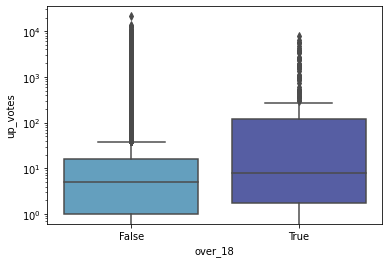

In [46]:
ax = sns.boxplot(x="over_18", y="up_votes", data=worldnews)
ax.set_yscale("log")

In [51]:
worldnews[worldnews.over_18 == True]\
    .sort_values(by='up_votes', ascending=False)[0:10]

,up_votes,title,over_18,author
date_created,,,,
2016-10-18,7941,"Judge presiding over El Chapo s case shot, killed while jogging outside home",True,IsleCook
2016-09-25,6322,"[NSFL] Australian child molester Peter Scully faces death penalty in Philippines - Scully filmed his torture and rape of young girls as he made them dig their own graves and laughed, joked and acted nonchalant about his alleged crimes",True,ExWhySaid
2016-01-07,5878,Armed suspect shot dead after trying to storm Paris police station,True,rawmas02
2016-05-17,5617,Syria Army killed over 200 ISIS militants in 3-day long offensive in Deir Ezzor,True,orangeflower2015
2014-09-05,5507,Man escapes ISIS execution,True,brothamo
2016-05-13,4839,ISIS massacre 14 Real Madrid fans at supporters club in Baghdad,True,PeterG92
2015-06-17,4209,"The fight is on to stop an annual Chinese event which is expected to involve the slaughter of more than 10,000 dogs, some of whom are burned or boiled alive.",True,ShakoWasAngry
2014-04-21,3831,China: “Violent Government Thugs” Beaten To Death By Angry Crowds After They Killed A Man Documenting Their Brutality,True,helpmesleep666
2016-01-18,3823,ISIS commits largest massacre since Syrian conflict by dumping 280 dead in the river and taking 400 hostages,True,AllenDono


# Text Analysis

In [425]:
import nltk
nltk.download(['stopwords','vader_lexicon','punkt'])

import pickle
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/viggyravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/viggyravi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/viggyravi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Creating title key words

First, I will tokenize the `titles` using the standard `word_tokenize` function from `nltk`. Then, I will create a word dictionary to evaluate the tokens `word_tokenize` has created.

In [428]:
stopwords = stopwords.words('english') + list(string.punctuation)
stopwords = stop_words + ['”', '“', '’', '‘', '..', '...'] + ['video','nsfw']

In [429]:
re1 = r"\w+"        # words only
re2 = r"\$"         # dollars
re3 = r"#[0-9]*\w+" # hashtags
re4 = r"\/[r]/\w+"  # subreddits

generic_re = re.compile("(%s|%s|%s|%s)" % (re1, re2, re3, re4))
tokenizer = nltk.RegexpTokenizer(generic_re)

In [ ]:
# TODO: example cases

In [447]:
tkzr = nltk.RegexpTokenizer(generic_re)
ltzr = WordNetLemmatizer()

def find_key_words(df_titles):    
    # tokenize using RegexpTokenizer
    tokens = df_titles.map(tkzr.tokenize)
    
    # remove stopwords and lemmatize
    for i, title in enumerate(tokens):
        tokens[i] = [ltzr.lemmatize(w.lower()) for w in title if w.lower() not in stopwords and len(w)>3]
        
    return tokens

In [448]:
%time key_words = find_key_words(worldnews.title)

CPU times: user 1min 12s, sys: 875 ms, total: 1min 13s
Wall time: 1min 13s


In [449]:
key_words[100:102]

date_created
2008-02-09    [japan, say, russian, bomber, violated, airspace, york, time]
2008-02-09                   [another, assault, suit, halliburton, covered]
Name: title, dtype: object

In [450]:
re_all_tokens = list(itertools.chain.from_iterable(key_words))
re_frqdst = nltk.FreqDist(t.lower() for t in re_all_tokens)
re_frqdst.most_common(10)

[('china', 26395),
 ('say', 25432),
 ('year', 21184),
 ('attack', 19819),
 ('syria', 19026),
 ('russia', 18772),
 ('world', 18241),
 ('state', 17094),
 ('government', 17014),
 ('police', 16660)]

## Tell me about

## Sentiment analysis

## Sentiment over time

# Categorizing titles using LDA

In [266]:
%load_ext autoreload
%autoreload

import pickle

import nltk
nltk.download([
    'stopwords',
    'vader_lexicon',
    'punkt'])

import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/viggyravi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/viggyravi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/viggyravi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 0: Define stopwords

In [6]:
stop_words = stopwords.words('english') + list(string.punctuation)
stop_words = stop_words + ['”', '“', '’', '‘', '..', '...'] + ['video','nsfw']

## Step 1: Select unique titles from dataset

In [180]:
titles = worldnews.title.unique()
titles[0:5]

array(['Scores killed in Pakistan clashes',
       'Japan resumes refuelling mission',
       'US presses Egypt on Gaza border',
       'Jump-start economy: Give health care to all ',
       'Council of Europe bashes EU&UN terror blacklist'], dtype=object)

## Step 2: Prepare data (remove stopwords and lemmatize)

In [98]:
# Step 2: Prepare Data (Remove stopwords and lemmatize)

lemmatizer = WordNetLemmatizer()

def process_data(titles):
    data_processed = []
    
    # for each title
    for title in titles:
        sent_out = []
        
        # for each word in title
        for wd in title.split():
            # remove stop words
            if wd not in stop_words:
                # lemmatize
                lemmatized_word = lemmatizer.lemmatize(wd)
                
                # find pos tag
                tag = nltk.pos_tag([lemmatized_word])
                
                # select important pos only
                if tag[0][1].startswith(('NN','VB','JJ','RB')): sent_out += [wd.lower()]
                else: continue
        
        data_processed.append(sent_out)
    
    return data_processed 

In [103]:
%time titles_processed = process_data(titles)

CPU times: user 12min 9s, sys: 3min 45s, total: 15min 55s
Wall time: 16min 3s


In [105]:
# glimpse at processed data
titles_processed[0:5]

[['scores', 'killed', 'pakistan', 'clashes'],
 ['japan', 'resumes', 'refuelling', 'mission'],
 ['us', 'presses', 'egypt', 'gaza', 'border'],
 ['jump-start', 'economy:', 'give', 'health', 'care'],
 ['council', 'europe', 'bashes', 'eu&un', 'terror', 'blacklist']]

In [107]:
# Save processed data
save('titles_processed', titles_processed)

Saved data to ./data/titles_processed.


## Step 3: Create the inputs of LDA model (dictionary, corpus)

In [7]:
titles_processed = load('titles_processed')

Loaded data from ./data/titles_processed.


In [119]:
%time dct = Dictionary(titles_processed)
print('Number of unique tokens: %d' % len(dct))

CPU times: user 9.08 s, sys: 0 ns, total: 9.08 s
Wall time: 9.08 s
Number of unique tokens: 201956


In [103]:
# Filter out words that occur less than 15 documents, or more than 100% of the documents.
dct.filter_extremes(no_below=29, no_above=1.0)

In [104]:
n = 8015
print('The word "' + dct[n] + '" appears in', dct.dfs[n],'documents')

The word "toppled" appears in 87 documents


In [120]:
dict(sorted(dct.items(), key=lambda item: item[1]))

{194855: '\x07illegal',
 4887: '!!',
 20234: '!!!',
 57994: '!!!!',
 35524: '!!!?',
 92162: '!!)',
 63573: '!!,',
 86221: '!!enjoy,thanks!!',
 72221: '!)',
 33014: '!=',
 112987: '!?',
 113927: '!north',
 34981: '#000000',
 13487: '#1',
 76379: '#1,',
 80090: '#1.',
 151428: '#10)',
 65850: '#11',
 42508: '#11:',
 66345: '#12',
 20125: '#12,',
 145757: '#126',
 118471: '#13:',
 169913: '#147notjustanumber:',
 181834: '#15girls',
 153324: '#17',
 15501: '#1:',
 40857: '#2',
 107409: '#2,',
 35355: '#2...',
 81072: '#203',
 9240: '#23:',
 102771: '#25s',
 104882: '#27o',
 77640: '#2:',
 24320: '#2s',
 65750: '#3',
 107738: '#3,',
 80396: '#3.',
 80183: '#31',
 37298: '#38:',
 45775: '#4',
 77188: '#4,',
 39289: '#40:',
 153724: '#48kmarch',
 81271: '#4;',
 77253: '#5',
 107739: '#5.',
 153319: '#52966',
 40858: '#54,295',
 138351: '#6',
 77254: '#6,',
 46893: '#7',
 18358: '#8',
 148120: '#8)',
 105574: '#8n',
 128381: '#9',
 149493: '#9)',
 162822: '#africa',
 172010: '#al_qaeda',
 1976

In [11]:
%time corpus = [dct.doc2bow(title) for title in titles_processed]
print('Number of documents: %d' % len(corpus))

CPU times: user 5.83 s, sys: 625 ms, total: 6.45 s
Wall time: 6.51 s


## Step 4: Train the LDA model

In [ ]:
%time lda_model = LdaMulticore(corpus=corpus,
                               id2word=dct,
                               random_state=100,
                               num_topics=9,          # 9 categories
                               passes=10,
                               chunksize=1000,
                               batch=False,
                               alpha='asymmetric',
                               decay=0.5,
                               offset=64,
                               eta=None,
                               eval_every=0,
                               iterations=100,
                               gamma_threshold=0.001,
                               per_word_topics=True)

# save the model
lda_model.save('lda_model.model')

In [ ]:
# See the topics
lda_model.print_topics(-1)

# Scratch Work

In [313]:
x = {'title': [test_remove, test_dollar, test_hashred]}
ah = pd.DataFrame(x)

In [315]:
ahh = ah.title.apply(lambda x: ' '.join(re.findall(generic_re, x)))
ahh

0                                                                       economy a aaa enjoy thanks u n illegal
1    $ 1 000 000 $ 1m $ 17 5 billion $ 160billion $ 125 each $ 16 billion a year $ 13 8 $ 100 000 $ 100 m year
2                                                                                #syria #48kmarch /r/legalnews
Name: title, dtype: object